#EDA on the IMDB Reviews Dataset and Training a FastText Model

###Logan Barnhart

This week I'll be examining the IMDB review dataset to understand what areas would benefit from its use, and then training a FastText model on it to become familiar with how to use the pre-implemented model for future projects.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import re

## Downloading the training data

I'm going to use tensorflow to download the data because they have a simpler implementation than pytorch. Before we get into any exploration I'll print the description of the dataset and an example of a positive and negative review. 

In [4]:
ds, info = tfds.load("imdb_reviews/plain_text", split = 'train', with_info = True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVYLRS7/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVYLRS7/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVYLRS7/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
print(info.description)

Large Movie Review Dataset. This is a dataset for binary sentiment
classification containing substantially more data than previous benchmark
datasets. We provide a set of 25,000 highly polar movie reviews for training,
and 25,000 for testing. There is additional unlabeled data for use as well.


In [175]:
#@title Example label and string: 
count = 0
for test in ds:
  if count == 0 or count == 3:
    print(f'Label: {test[1].numpy()}')  
    temp = ''.join(chr(i) for i in test[0].numpy())
    print(f'String: \'{temp}\'')
  if count == 3:
    break
  count += 1

Label: 0
String: 'This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.'
Label: 1
String: 'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gentl

Now we know a label of 0 appears to classify negative reviews while 1 correlates to positive reviews and they are indeed very polar.


### Exploring the Data

Now we can collect some information. In the following code cell I'm just iterating throughout all the reviews to count the number of positive and negative reviews, along with creating a dictionary of all 1-word-grams and the number of times they occur.

After that I have hidden a code cell containing print statements, dictionary sorting, and plotting commands. 

In [177]:
labelcounts = {0 : 0, 1: 0}
vocab = {}

for rating in ds:
  labelcounts[rating[1].numpy()] += 1

  #changing tensor -> string and splitting at punctuation / spaces
  review = ''.join(chr(i).lower() for i in rating[0].numpy())
  split = re.split('\W+', review)

  for word in split:
    if word in vocab.keys():
      vocab[word] += 1
    else:
      vocab[word] = 1

Total counts of each label:  {0: 12500, 1: 12500}
Number of unique 1-gram phrases:  75573
Most frequently occurring word: the - 336743 occurrences
Total word count: 6084324




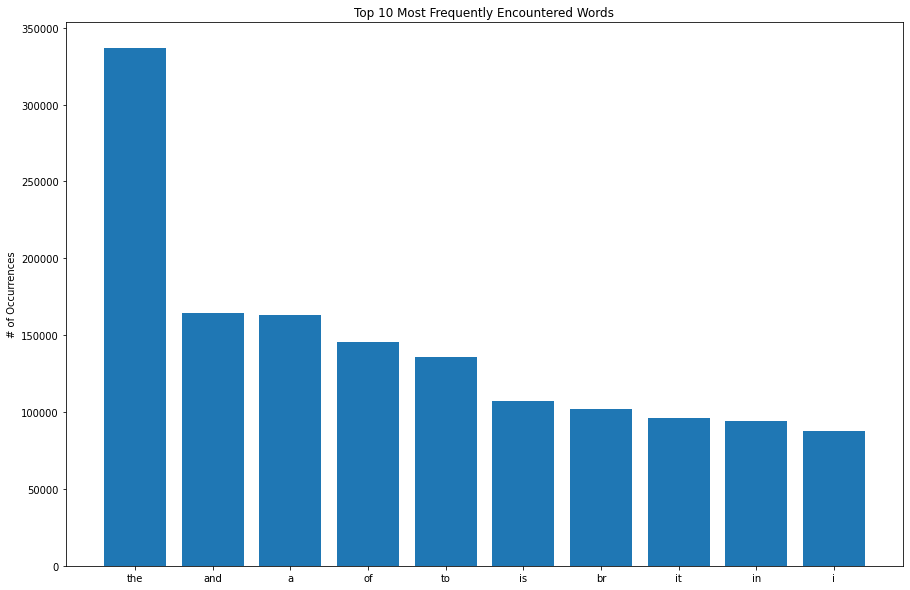

In [180]:
#@title Printing/Plotting Code

print('Total counts of each label: ', labelcounts)
print('Number of unique 1-gram phrases: ', len(vocab.keys()))
print(f"Most frequently occurring word: {max(vocab, key = vocab.get)} - {vocab[max(vocab, key = vocab.get)]} occurrences")
print('Total word count:', sum(vocab.values()))
print('\n')

#sort the dictionary and 
vocabsort = sorted(vocab.items(), key=lambda x:x[1], reverse=True)
barlabels = [vocabsort[i][0] for i in range(10)]
barvalues = [vocabsort[i][1] for i in range(10)]
fig, ax = plt.subplots(1,1,figsize = (15,10))
plt.bar(barlabels, barvalues)
plt.ylabel('# of Occurrences')
plt.title('Top 10 Most Frequently Encountered Words')
plt.show()

So, we have an even distribution of positive and negative reviews for the training set. with nearly 100,000 unique words. The distribution of words appears to be what we'd expect from [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law).  Lastly there are 6 million words across all the reviews. 

Next, I'd like to try out a visualization technique I haven't done before - my goal is to create a word cloud for 1000 positive and 1000 negative reviews to see if there are any words that occur more frequently across each type of review. 

A word cloud is a visualization of the words in a string by plotting the most frequent phrases larger than less frequent phrases. 

The code below:

* Turns the tensor review into a string
* concatenates it onto the correct string depending on whether a review is positive of negative
* repeats until each category has 1000 concatenated strings
* generates and plots the wordclouds

Text(0.5, 1.0, 'Negative')

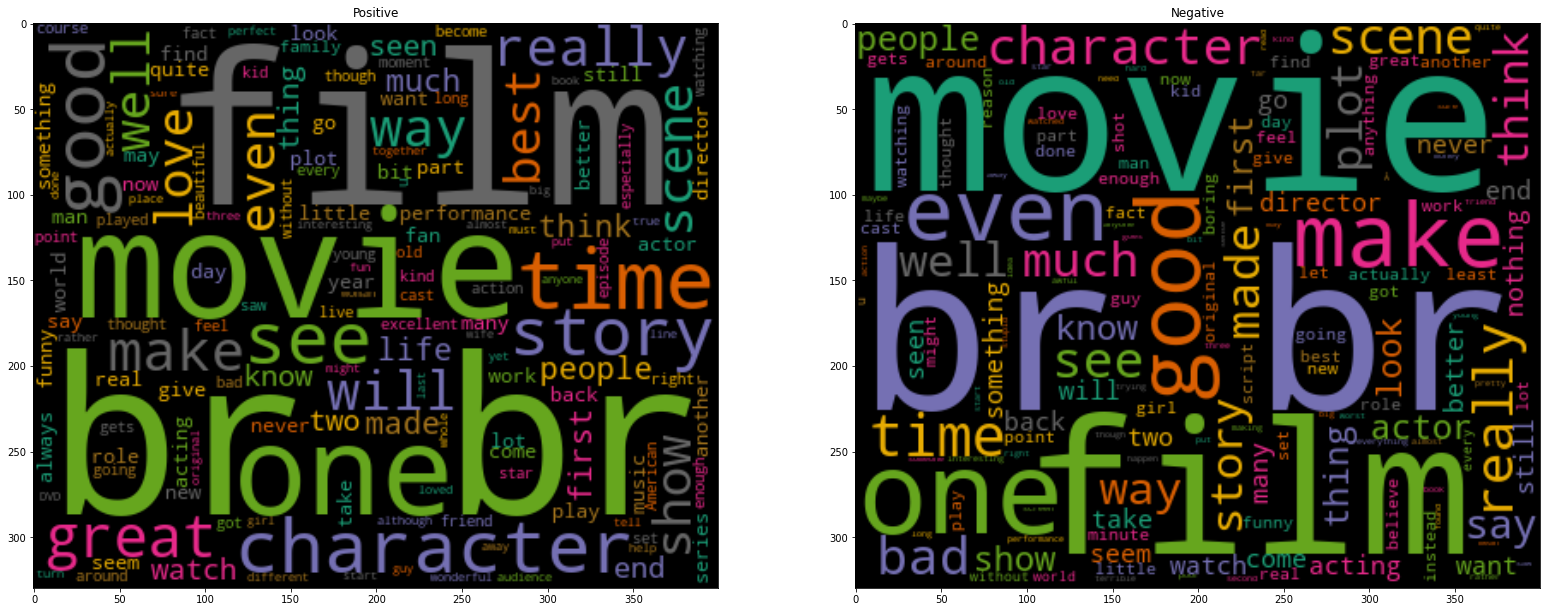

In [128]:
from wordcloud import WordCloud

positive_string = ''
negative_string = ''
positive_count = 0
negative_count = 0

for review in ds:
  string = ''.join(chr(i) for i in review[0].numpy()).strip()

  if negative_count < 1000 and review[1].numpy() == 0:
    negative_count += 1
    negative_string += ' ' + string

  if positive_count < 1000 and review[1].numpy() == 1:
    positive_count += 1
    positive_string += ' ' + string

  if positive_count >= 1000 and negative_count >= 500:
    break

fig, ax = plt.subplots(1, 2, figsize = (27,23))
positive_wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(positive_string)
negative_wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(negative_string)

ax[0].imshow(positive_wc, interpolation = 'bilinear')
ax[0].set_title('Positive')
ax[1].imshow(negative_wc, interpolation = 'bilinear')
ax[1].set_title('Negative')

This allows for analysis that's more qualitative than quantitative since it does rely on some 'eyeballling.' From an initial glance, it seems like the distribution of words between a type of review is mostly similar. 

I spent a few minutes looking through each plot and the only word unique to a positive review I could see was 'great' and the only word I could find unique to negative reviews was 'bad.'

Sidenote, the 'br' blurb is the newline character, and I tried a few methods to strip the strings of this character but none of them worked. 

This technique is very promising to me because it allows for rapid generalizations about different categories of strings. 

###Big Takeaway

__Although it doesn't appear that there are any frequently used words unique to positive/negative reviews, this actually tells us that an effective model has to learn more nuanced patterns than simple vocabulary usage to perform accurately on this dataset.__

The final thing I'll do in this data exploration is examine the average string length for positive/negative reviews:

In [181]:
positive_length = 0
negative_length = 0

# sum review lengths
for review in ds:
  if review[1] == 0:
    negative_length += len(review[0].numpy())
  else:
    positive_length += len(review[0].numpy())

#calculate average
positive_length /= 12500
negative_length /= 12500

print(f'Average length of positive review: {positive_length} characters')
print(f'Average length of negative review: {negative_length} characters')

Average length of positive review: 1347.42648 characters
Average length of negative review: 1303.19936 characters


So, positive reviews tend to be just slightly longer than negative reviews, maybe by 3 or four words, but for the most part people are writing similar amounts about movies they do and do not like. 

# Exploring FastText - A Bag of tricks for efficient text classification

Next we're going to use this data to train a FastText model to see just how fast it trains, and how accurate it is!

## Formatting our data

Unfortunately, the model takes very particular .txt files to train, so we will first take the tensorflow dataset to format one correctly. 

The necessary format is: 

'\_\_label__{Label here} {Text}'



In [ ]:
f = open("imdb_train.txt", "a")

for review in ds:
  label = '__label__' + str(review[1].numpy())
  review = ''.join(chr(i) for i in review[0].numpy()) + '\n'
  newline = label + ' ' + review
  f.write(newline)

f.close()

## Loading model architecture and training

We need to install the fasttext library, and all the steps will be simple after that.

In [ ]:
!pip install fasttext

In [158]:
import fasttext

model = fasttext.train_supervised(input = 'imdb_train.txt')

Okay - that just trained on 6 million words in 13 seconds running on a cloud based computing service! That's really impressive performance.

##Evaluating the model

Let's invent some reviews and make a couple predictions just to see if everything is working:

In [159]:
model.predict('I hate rambo! I hate it. Worst movie ever.')

(('__label__0',), array([0.84580487]))

In [160]:
model.predict('I love rambo! LOVE IT! Best movie ever.')

(('__label__1',), array([1.00000596]))

In [168]:
model.predict('Rambo was a movie in which I wrestled whether I actually liked it or not. Im still not sure but I do think that the cinematography was good even if it was slightly lacking in plot.')

(('__label__1',), array([0.56600678]))

It seems to perform pretty well! It predicted all of those 'reviews' correctly, both rudimentary ones and longer perhaps more ambiguous ones. 

## Installing and formatting test data 

Now let's install the actual test data, format it, and see how the model performs on a larger set of data. 

In [169]:
test_ds = tfds.load("imdb_reviews/plain_text", split = 'test', as_supervised=True)

f = open("imdb_test.txt", "a")

for review in test_ds:
  label = '__label__' + str(review[1].numpy())
  review = ''.join(chr(i) for i in review[0].numpy()) + '\n'
  newline = label + ' ' + review
  f.write(newline)

f.close()

In [174]:
model.test('imdb_test.txt')

(25000, 0.85972, 0.85972)

Just for reference, the evaluation took less than two seconds to complete. 

The first element in the tuple corresponds to the number of samples tested on, the second element is the accuracy, and the final element is the recall. For now let's just focus on the accuracy, the model is correct 86% of the time which is really impressive for such a small training dataset and such fast training time. 

To better understand their interpretation of accuracy and recall, let's look at one more example:

In [173]:
model.test('imdb_test.txt', k = 2)

(25000, 0.5, 1.0)

When we add `k = 2` as a parameter, the model will now evaluate accuracy on the top-2 predictions. Since we only have two labels, the top two predictions is some ordering of 1 and 0. So one out of two predictions is always correct which is why accuracy is 0.5, but the correct prediction is always present which is why the recall is 1.0

More generally, the accuracy is an average across all predictions of the weighted accuracy out of k predictions (1/k if correct label present) while the recall is the percentage of the time the correct label was in the top k predictions. 

#Conclusions

## IMDB Review Dataset:
Overall the dataset seems like a pretty reliable dataset especially for simple testing because of its size. There doesn't appear to be any obvious bias in the distribution of words (other than film related words) between positive and negative reviews and it's probably a solid dataset for some baseline learning. 

## FastText

This model is exactly as it advertises, incredibly fast. It seemed to have low overhead, the memory and COU usage provided to me in colab wasn't ever close to being at capacity during training or evaluation. 

Like we covered in class, without visiting any other datasets it seems like a good baseline to compare new models to because it's surely not the most accurace considering models we have access to today, but it does train quickly and effectively enough to compare other models to without wasting any resources. 

### Future Exploration
I'd like to explore and implement the FastText algorithm. This week I was short on time and the finer details of the model escaped me while reading the paper, so sadly I didn't have enough time to fully delve into the code repository to do so. 

### Citations:

FastText Official Tutorial: https://fasttext.cc/docs/en/supervised-tutorial.html

FastText Official Github: https://github.com/facebookresearch/fastText 
